In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor,plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pickle



In [5]:
df = pd.read_csv('../data/year_lag_data.csv')


In [6]:

target = 'Weekly_Sales'

X = df.drop(columns=target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Store', 'Dept', 'IsHoliday', 'Type']
numerical_features = [col for col in X.columns if col not in categorical_features and col != "Date"]



In [7]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = XGBRegressor(objective='reg:squarederror', random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Mean Squared Error (MSE): 9501968.29
Mean Absolute Error (MAE): 1214.37
R-squared (R2): 0.98


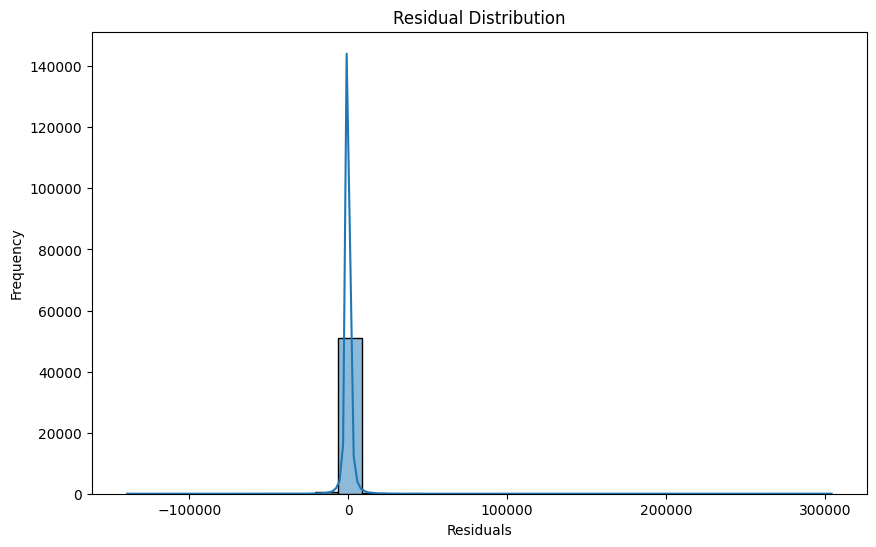

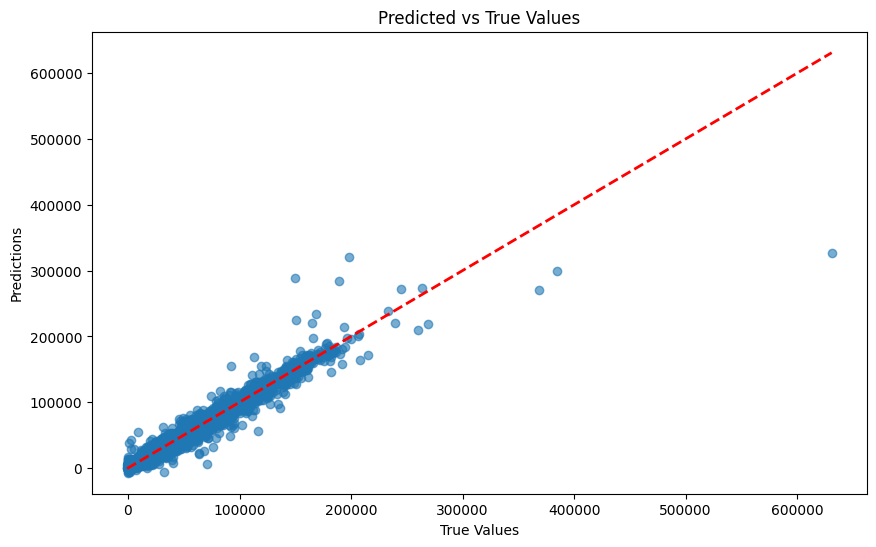

In [8]:
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


In [15]:
with open('../src/models/year_prediction_xgboost.pkl', 'wb') as file:
    pickle.dump(model, file)

In [9]:
X_test['Date'] = pd.to_datetime(X_test['Date'])
X_test['Predicted_Weekly_Sales'] = y_pred
X_test['True_Weekly_Sales'] = y_test




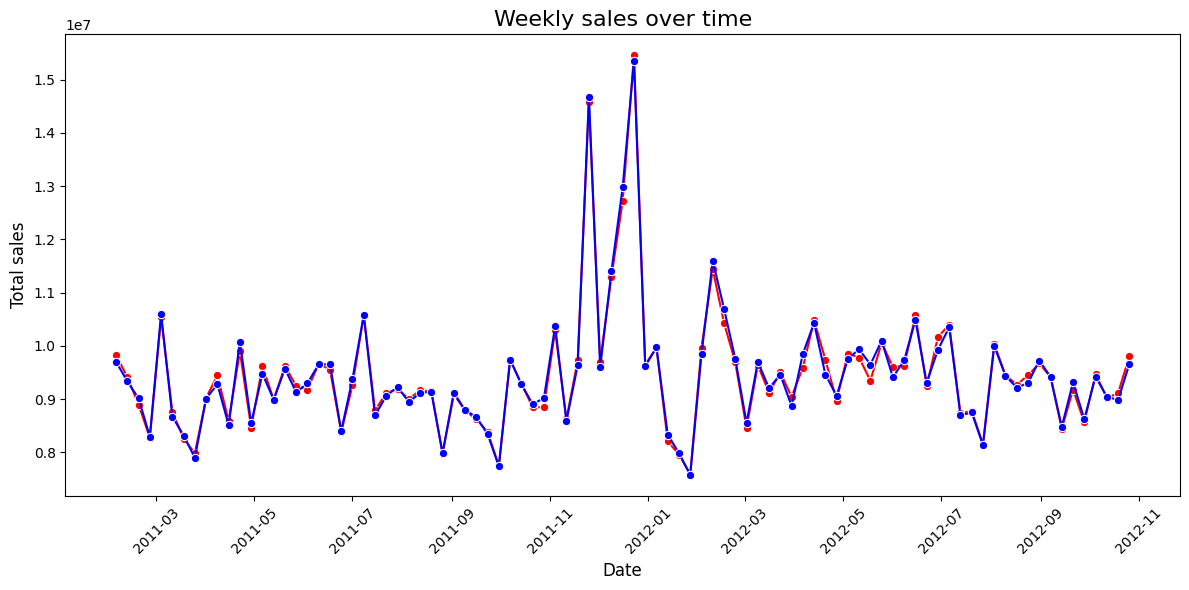

In [13]:

weekly_sales_true = X_test.groupby('Date')['True_Weekly_Sales'].sum().reset_index()
weekly_sales_pred = X_test.groupby('Date')['Predicted_Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales_pred, x='Date', y='Predicted_Weekly_Sales', marker='o', color='r')
sns.lineplot(data=weekly_sales_true, x='Date', y='True_Weekly_Sales', marker='o', color='b')
plt.title('Weekly sales over time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


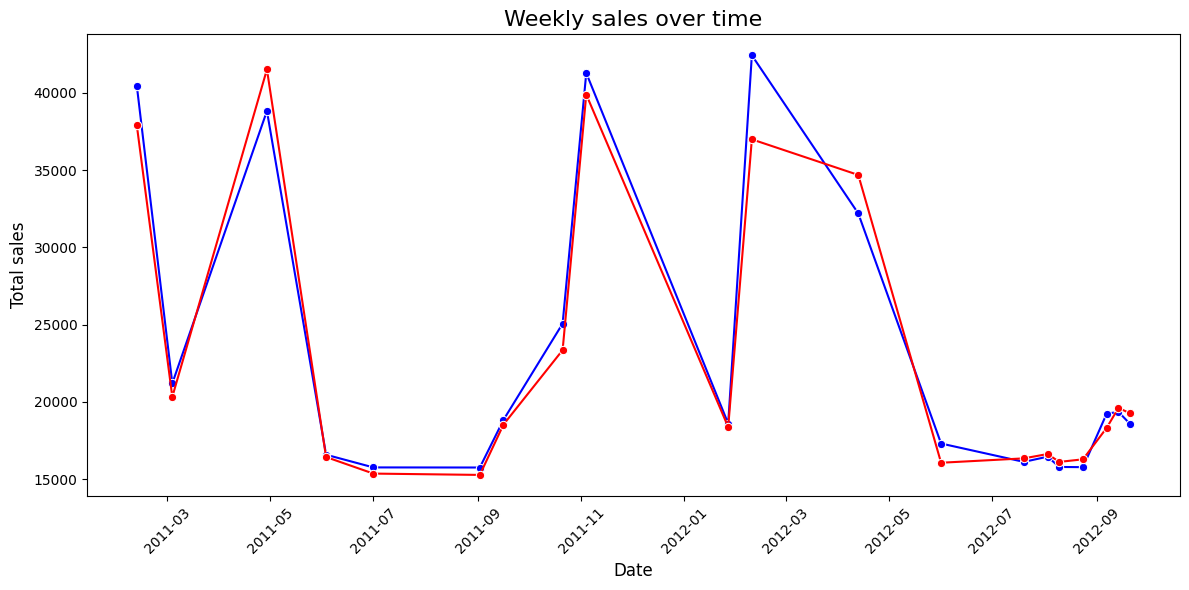

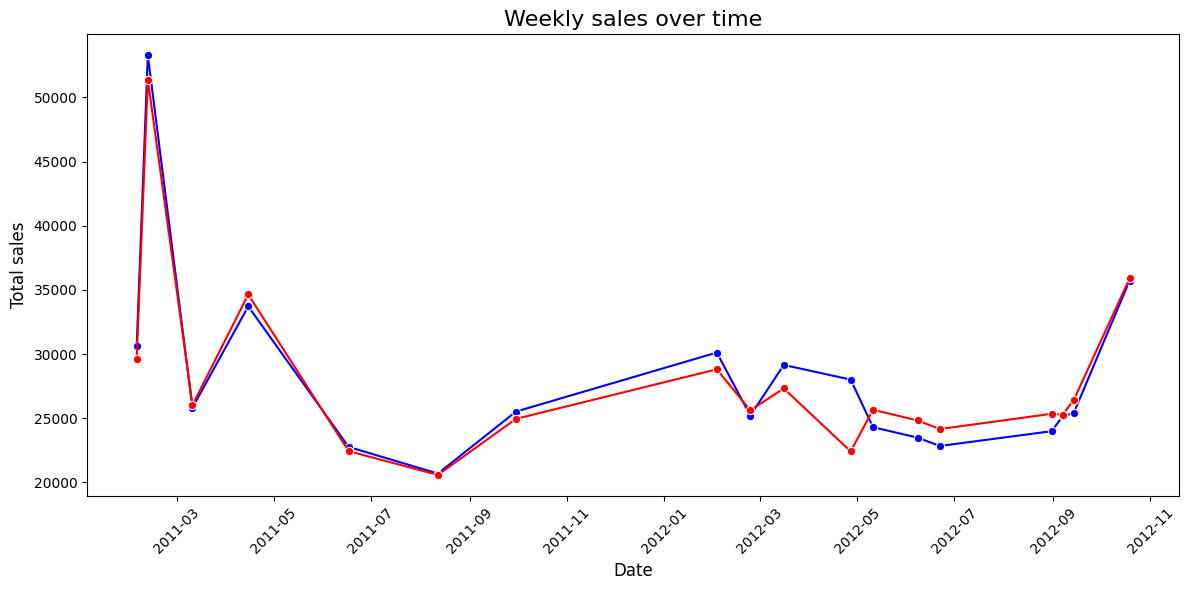

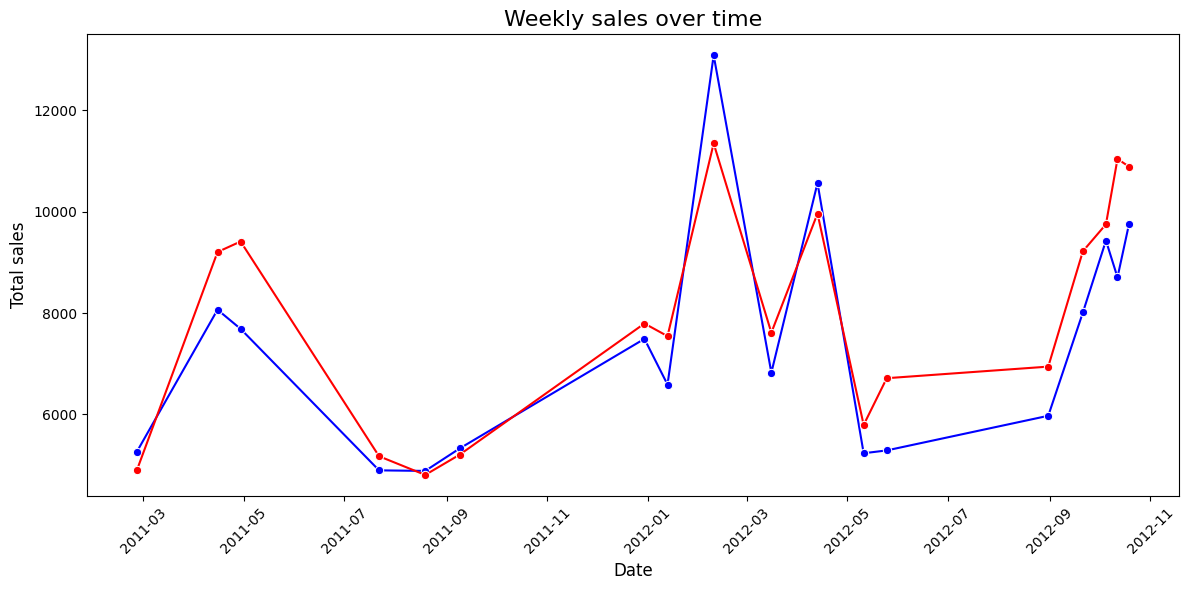

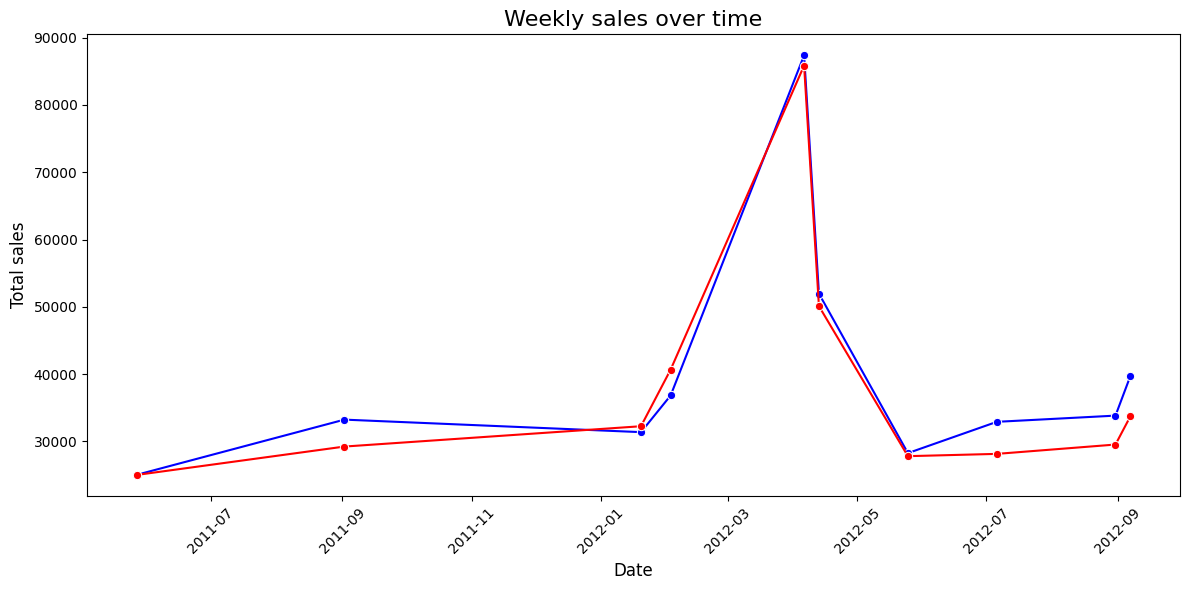

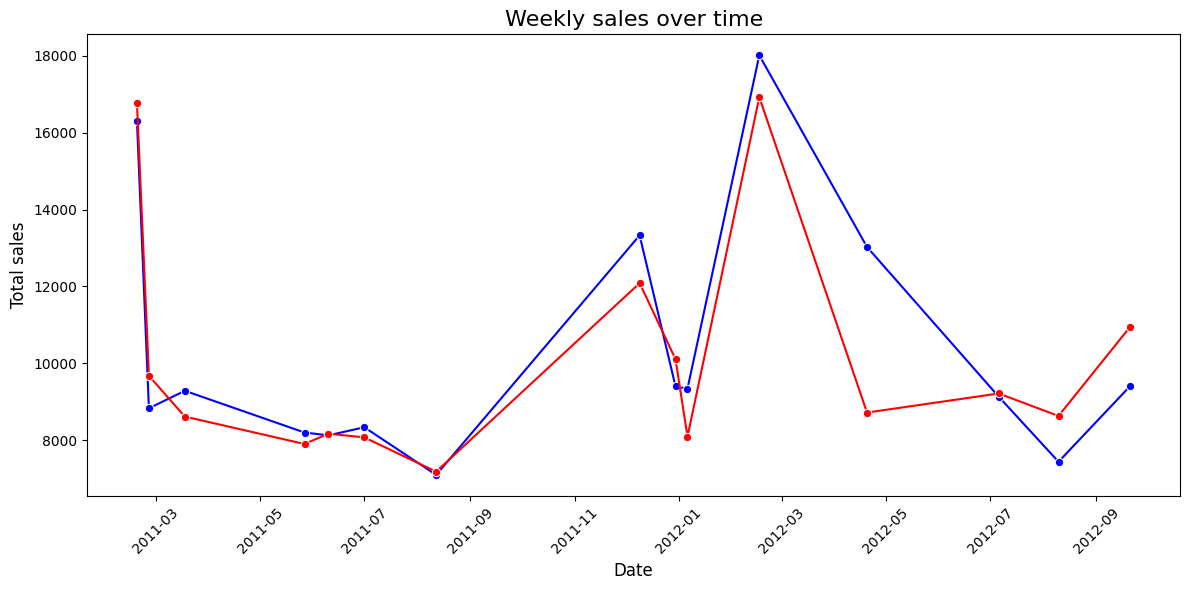

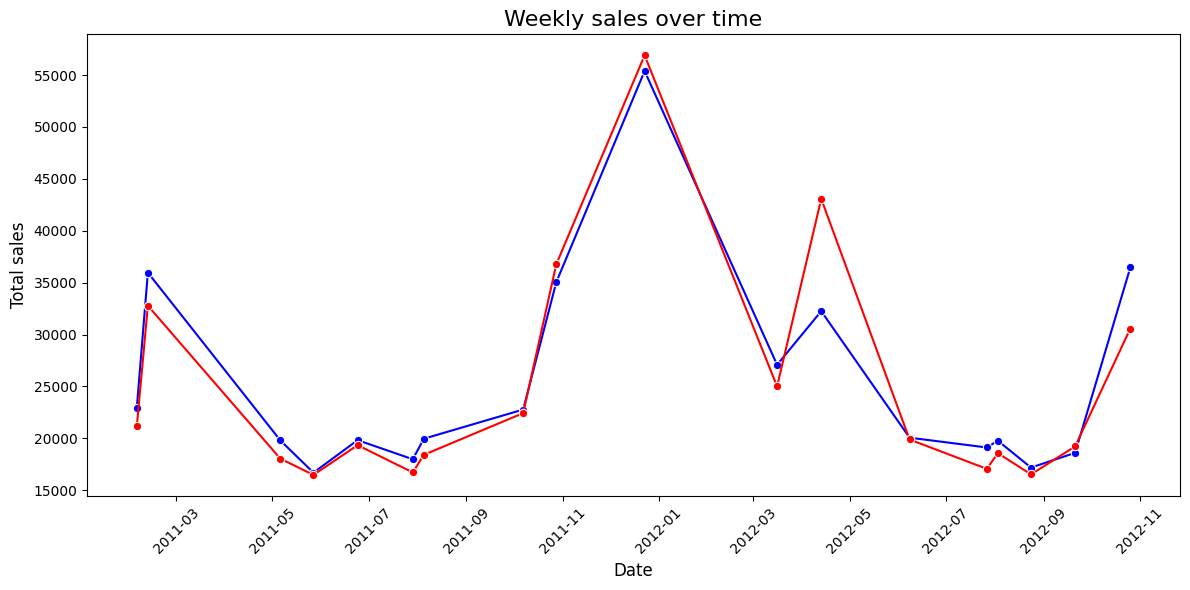

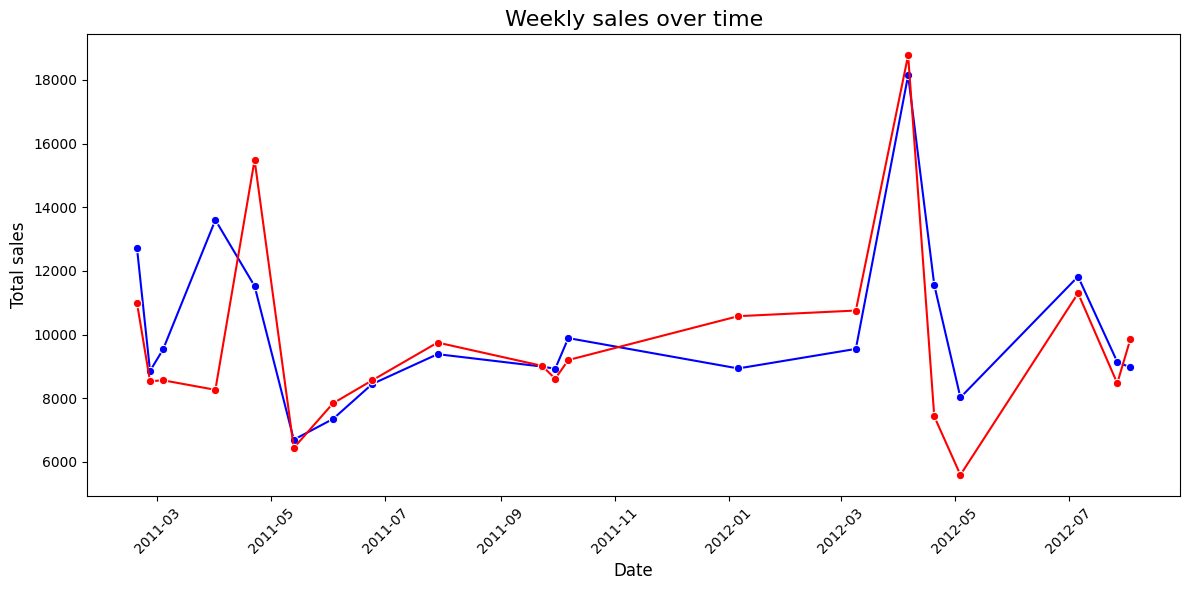

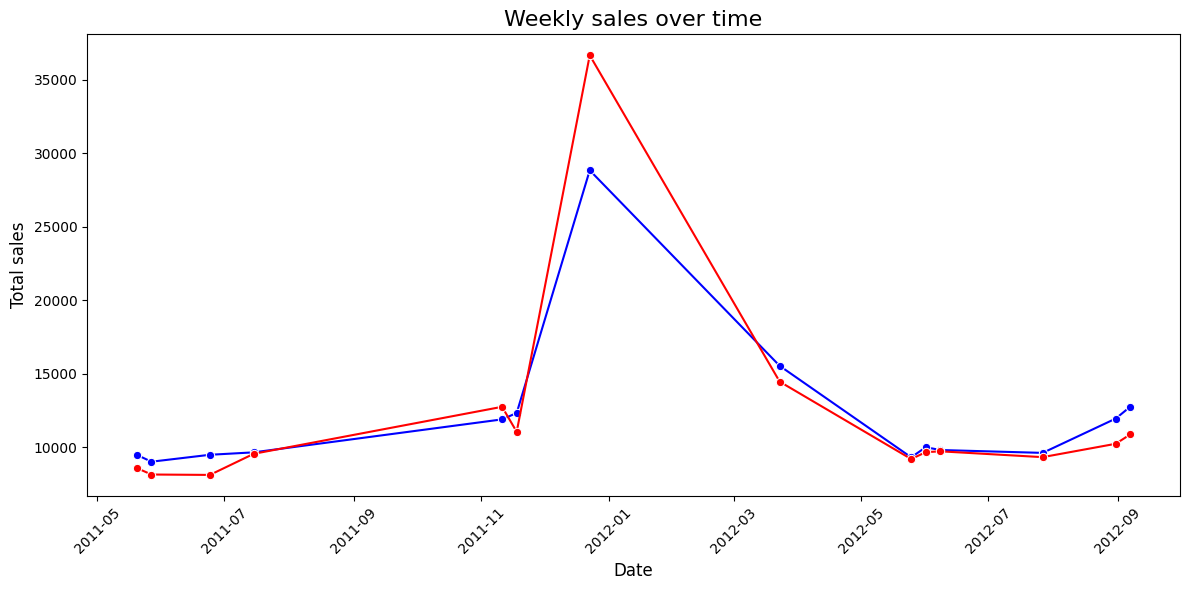

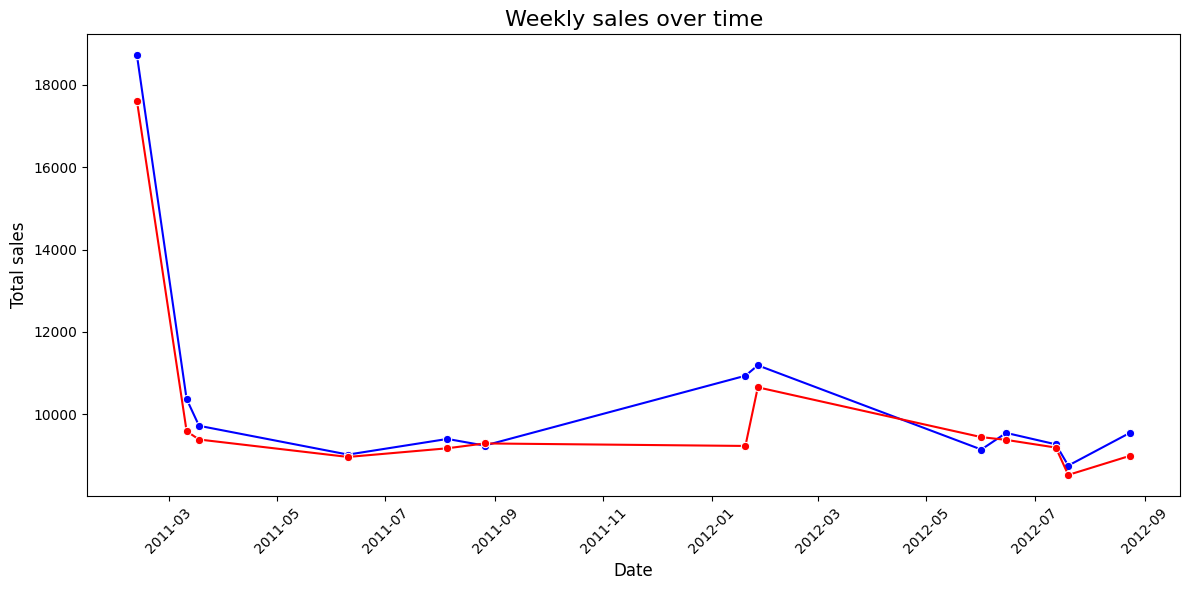

In [12]:
for i in range(1,10):
    store = X_test[(X_test['Store'] == i) & (X_test['Dept'] == 1)]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=store, x='Date', y='Predicted_Weekly_Sales', marker='o', color='b')
    sns.lineplot(data=store, x='Date', y='True_Weekly_Sales', marker='o', color='r')
    plt.title('Weekly sales over time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total sales', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()